# Check predictions

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
root_path = os.path.abspath("..")
if root_path not in sys.path:
    sys.path.append(root_path)
    
os.environ['PRETRAINED_MODELS'] = '../../../pretrained-models.pytorch/'
os.environ['IGNITE_PATH'] = '../../../pytorch-ignite-master/'
ignite_path = os.environ['IGNITE_PATH']
if ignite_path not in sys.path:
    sys.path.append(ignite_path)

In [4]:
CONFIG = {
    "seed": 7777,
    "batch_size": 32,
    "num_workers": 12,

    "test_aug": {
        "Compose": {
          "transforms": [
            {"RandomAffine": {"translate": [0.1, 0.1], 
                                "rotation": [-2, 2],                                             
                                "interpolation": 0}},              
            {"RandomFlip": {"mode": "h", "proba": 0.5}},
            {"RandomFlip": {"mode": "v", "proba": 0.5}},
            {"_ToTensor": {}}
          ]
        }
    },
    
    
    "models": [
        {
            "name": {"IcebergInceptionV4": {"input_n_channels": 2}}, 
            "weights_path": "../output/logs_IcebergInceptionV4_20171201_0800/fold_0"
        }
    ],
    
    "n_tta": 3
    
}

## Dataflow

In [5]:
from common.dataflow import get_test_batches

In [8]:
test_batches = get_test_batches(CONFIG['test_aug'], CONFIG['batch_size'], CONFIG['num_workers'], CONFIG['seed'])

In [7]:
len(test_batches), CONFIG['batch_size'] * len(test_batches), len(test_batches.dataset), CONFIG['batch_size']

(264, 8448, 8424, 32)

In [9]:
for i, ((batch_x, _), batch_y) in enumerate(test_batches):
    break

In [10]:
type(batch_x), batch_x.size(), type(batch_y)

(torch.cuda.FloatTensor, torch.Size([32, 2, 75, 75]), list)

## Models

In [12]:
CONFIG['models']

[{'name': {'IcebergInceptionV4': {'input_n_channels': 2}},
  'weights_path': '../output/logs_IcebergInceptionV4_20171201_0800/fold_0'}]

In [13]:
from common import find_weights_filepath
from common.models import *
from common.torch_common_utils.deserialization import restore_object, CustomObjectEval
from common.torch_common_utils.training_utils import load_checkpoint

In [14]:
models = {}
custom_objects = CustomObjectEval(globals=globals())

for s in CONFIG['models']:
    m = restore_object(s['name'], custom_objects=custom_objects, verbose_debug=False)
    path = find_weights_filepath(s['weights_path'])
    load_checkpoint(path, m)
    models[m.__class__.__name__] = m.cuda()
    break

Load checkpoint: ../output/logs_IcebergInceptionV4_20171201_0800/fold_0/model_val_loss=0.1877.pth.tar


## Run predictions

In [1]:
from common.torch_common_utils.testing_utils import predict
from torch.nn.functional import softmax

ImportError: No module named 'common'

In [11]:
for name in models:
    model = models[name]
    y_preds, data_ids = predict(model, test_batches, to_proba_fn=softmax)
    break

### Load saved predictions

In [26]:
import os
import numpy as np

In [27]:
output_path = os.path.join("..", "output", "predictions_config_single_network_20171203_1500_20171203_1628")

In [28]:
filename = os.path.join(output_path, "y_probas_0_IcebergInceptionV4.npz")
ret = np.load(filename)

In [29]:
y_probas = ret['y_probas']
data_ids = ret['data_ids']

In [30]:
output_path = os.path.join("..", "output", "predictions_config_kfolds_inceptionv4_20171203_1100_20171203_2047")

In [31]:
filename = os.path.join(output_path, "y_probas_0_IcebergInceptionV4.npz")
ret = np.load(filename)

In [32]:
y_probas2 = ret['y_probas']
data_ids2 = ret['data_ids']

In [8]:
from common.dataflow import get_image_by_id, get_test_df

In [9]:
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

from common.dataflow_visu_utils import display_image

In [10]:
test_df = get_test_df()

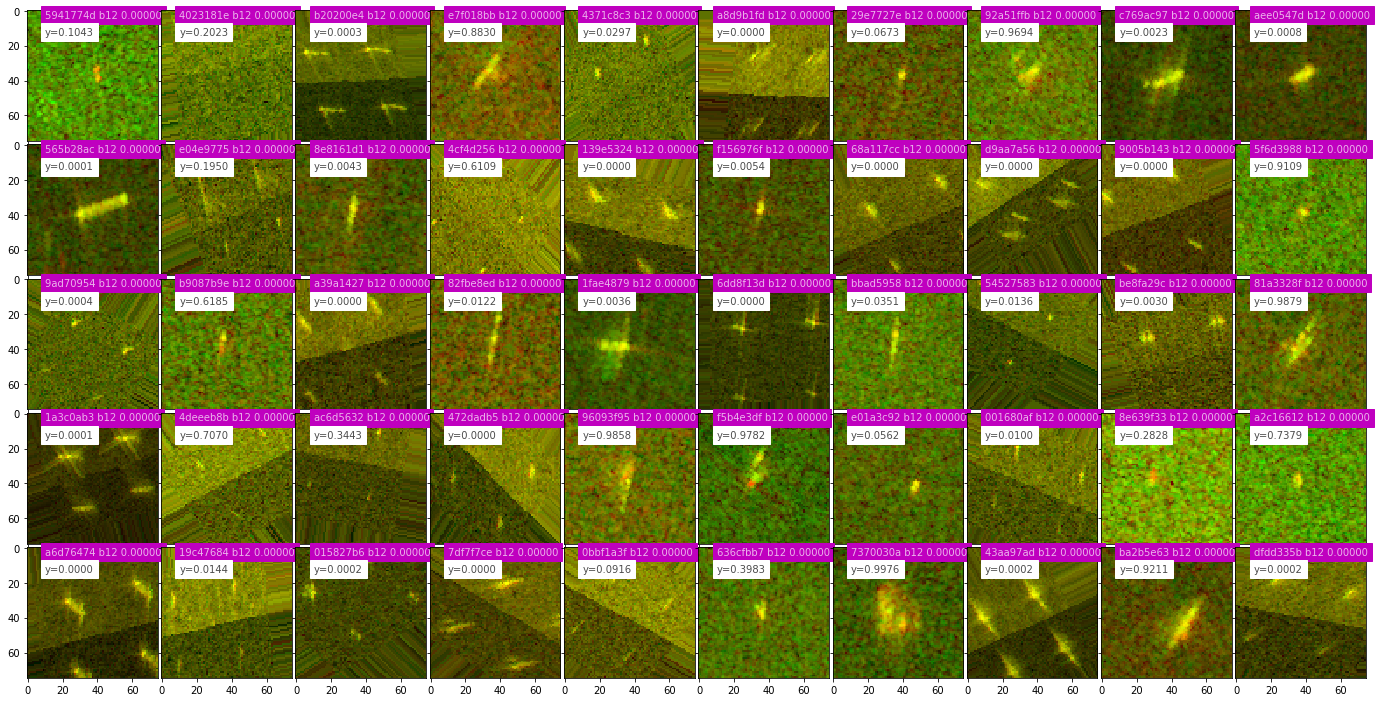

In [16]:
nx = 10
ny = 5

fig = plt.figure(figsize=(24,24))
grid = ImageGrid(fig, 111, nrows_ncols=(ny, nx), axes_pad=0.05)

i = 0
j = 0
for k, (image_id, y_proba) in enumerate(zip(data_ids, y_probas)):

    x = get_image_by_id(image_id, test_df)
    ax = grid[k]
    display_image(ax, x, image_id, "b12", 0, target="%.4f" % y_proba[1])
    i = (i + 1) % nx
    if i == 0:
        j = (j + 1) % ny
        if j == 0:
            break

In [17]:
from common.dataflow import SAMPLE_SUBMISSION_PATH

In [53]:
y_is_iceberg_proba = y_probas[:, 1]

In [55]:
y_is_iceberg_proba[y_is_iceberg_proba < 0.03] = 0.03
y_is_iceberg_proba[y_is_iceberg_proba > 0.97] = 0.97

In [56]:
y_is_iceberg_proba

array([ 0.10433347,  0.20233904,  0.03      , ...,  0.03      ,
        0.97000003,  0.03      ], dtype=float32)

In [22]:
import pandas as pd

def write_submission(output_filename, data_ids, y_probas):
    submission_df = pd.read_csv(SAMPLE_SUBMISSION_PATH) 
    y_is_iceberg_proba = y_probas[:, 1]
    y_is_iceberg_proba[y_is_iceberg_proba < 0.03] = 0.03
    y_is_iceberg_proba[y_is_iceberg_proba > 0.97] = 0.97   
    submission_df['is_iceberg'] = y_is_iceberg_proba
    submission_df.to_csv(output_filename, index=False)

In [23]:
output_filename = os.path.join(output_path, "test.csv")

In [24]:
write_submission(output_filename, data_ids, y_probas)

In [25]:
!head -n 10 ../output/predictions_config_single_network_20171203_1500_20171203_1628/test.csv

id,is_iceberg
5941774d,0.10433346778154373
4023181e,0.2023390382528305
b20200e4,0.029999999329447746
e7f018bb,0.8830026984214783
4371c8c3,0.029999999329447746
a8d9b1fd,0.029999999329447746
29e7727e,0.06733447313308716
92a51ffb,0.9694427847862244
c769ac97,0.029999999329447746
